# 🧠 Brain Disorder Diagnosis

# 💭 Introduction

Brain disorders are often associated with abnormal neurological, behavioral, or anatomical patterns. One example is **Autism Spectrum Disorder (ASD)**, a lifelong neurodevelopmental condition affecting more than 1% of children. ASD is characterized by a range of symptoms, including:
- Deficits in social communication
- Varying levels of disability
- Repetitive behavioral patterns
- Restricted interests

:::{figure} figures/abide.png
Autism Brain Imaging Data Exchange
:::

Diagnosing ASD remains a challenging task due to behavioral heterogeneity and complex neuroanatomical abnormalities. Non-invasive neuroimaging techniques, especially magnetic resonance imaging (MRI), and in particular, resting-state functional MRI (rs-fMRI) have shown potential in identifying key biomarkers associated with ASD. These biomarkers are often located in specific **regions of interest (ROIs)** within the brain. These ROIs are normally defined through a brain mapping called an **atlas** that normally have its own definition of ROIs for its intended use cases.

However, MRI data collected from a single site (e.g., a research institution or hospital) typically involve a limited number of subjects, due to the high cost of MRI scans and the challenge of recruiting patients. To overcome this limitation, large-scale collaborative efforts are often established. One such effort is the [Autism Brain Imaging Data Exchange (ABIDE)](https://fcon_1000.projects.nitrc.org/indi/abide/), a publicly available multi-site dataset that aggregates data from over 16 independent sites, comprising over 1,035 subjects.

Machine learning (ML) models have demonstrated promising results in analyzing fMRI data, with **functional connectivity (FC)**, the pairwise correlation or covariance between ROIs being a standard representation. Despite the availability of larger datasets like ABIDE, modeling ASD remains difficult due to significant inter-site variability. These include differences in participant phenotypes, MRI scanner specifications, and preprocessing pipelines, all of which can hinder the effective integration of multi-site data. Therefore, a key challenge lies in how to harmonize these heterogeneous sources to build robust models for ASD diagnosis.

# 📖 Problem Formulation

This notebook builds upon the work of [Kunda et al. (2022)](https://eprints.whiterose.ac.uk/id/eprint/191961/1/MultisiteASD_TMI_2022.pdf), published in *IEEE Transactions on Medical Imaging*. The authors address the following key research questions:

- **Between-site heterogeneity**: How can we effectively account for experimental differences in the ABIDE rs-fMRI dataset?
- **Discriminative features**: Can we design novel rs-fMRI features to improve autism classification?

To answer these questions, the authors propose:
- A second-order functional connectivity representation called **Tangent-Pearson**, which captures more discriminative features for ASD prediction.
- The use of **domain adaptation** to mitigate inter-site heterogeneity present in multi-site neuroimaging data.

# 📝 Objectives

In this notebook, we adopt the same approach by treating the ABIDE dataset as a **binary classification problem**, where the target label indicates the subject's diagnostic group: ASD (positive) or control (negative).

:::{figure} figures/flowchart.png
Machine learning pipeline to predict ASD vs control subjects.
:::

The figure above outlines the pipeline used in this tutorial:

1. **Load Brain Signals and Phenotypic Information**:  
   We begin by loading ROI-based time series extracted from resting-state fMRI scans. Each time series represents blood-oxygen-level-dependent (BOLD) activity in a specific brain region (e.g., medial prefrontal cortex). Additionally, we load subject-level phenotypic information such as site, age at scan, sex, handedness, and eye status.

2. **Construct Brain Networks**:  
   From the ROI time series, we compute functional connectivity (FC) matrices using methods like **Partial Correlation** or **Tangent-Pearson**, which characterize inter-regional relationships.

3. **Learn Site-Independent Features**:  
   To reduce site-related variability, we apply **domain adaptation** technique to project the data into a space where site effects are reduced.

4. **Predict ASD vs Control**:  
   We use **linear classifiers** such as **logistic regression**, **SVM**, or **ridge classifiers** to predict the subject’s condition. These models are chosen for their inherent interpretability, as the learned weights directly highlight the importance of each ROI or ROI-ROI connection.

5. **Compute Accuracy and AUROC**:  
   Model performance is evaluated using **accuracy** and **area under the receiver operating characteristic curve (AUROC)**.

6. **Visualise Patterns**:  
   Finally, we interpret the trained model to identify discriminative brain networks that are most indicative of ASD. To do this, we use **brain connectome visualizations** to show the spatial locations of the associated brain regions and their connections, highlighting patterns linked to the diagnostic outcome.

To do this, we use [**PyKale**](https://github.com/pykale/pykale) to conveniently build the pipeline proposed by Kunda et al. (2022) for modeling multi-site datasets such as ABIDE. 

Along the way, we include short-and-quick exercises to enhance understanding and engagements throughout the tutorial.

:::{warning}
This notebook does not cover the full scope of building a complete machine learning pipeline for neuroimaging. In particular, we omit the preprocessing steps required to transform raw neuroimaging data into brain signals, due to the complexity, variability, and computational demands of such procedures.

Recent efforts, such as the **Brain Imaging Data Structure (BIDS)**, have introduced standardized formats for organizing neuroimaging datasets. However, the **ABIDE dataset** does not conform to this standard. As a result, unlike other tutorials that support fully integrated data loading and preparation using PyKale, neither this notebook nor PyKale itself provides such functionality at the time of writing.

Additionally, due to the limited computational resources available in **Google Colab** (the intended execution environment), we do not include detailed instructions for manually extracting FC features in this notebook. Nevertheless, we provide optional helper functions for users interested in performing this step, which will be explained in a later section.
:::

# 🏞️ Environment Preparation

As a starting point, we will install the required packages and load a set of helper functions to support the tutorial workflow. To keep the output clean and focused on interpretation, we will also suppress warnings.

Several helper scripts are provided to modularize the code and streamline the workflow. These scripts are located in the current working directory of the notebook and can be inspected directly as `.py` files. The helper scripts include:

- **`config.py`**: Defines base configuration settings, which can be customized or overridden using external `.yml` files.
- **`data.py`**: Provides data loading functions and utilities for automatically downloading required datasets.
- **`parsing.py`**: Contains utilities for compiling and summarizing evaluation results, as well as parsing the hyperparameter grid defined in the configuration.
- **`preprocess.py`**: Handles phenotype preprocessing, including missing value imputation, categorical variable encoding, and FC extraction from the brain signals.
- **`visualization.py`**: Provides functions to visualize functional connectivity (FC) examples and the distribution of phenotypic variables.

Throughout the tutorial, we will provide further explanations on the contents and roles of these helper scripts as they are used.

In [ ]:
import os
import site
import sys
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

if "google.colab" in str(get_ipython()):
    sys.path.insert(0, site.getusersitepackages())
    !git clone -b brain-decoding https://github.com/pykale/embc-mmai25.git
    %cp -r /content/embc-mmai25/tutorials/brain-disorder-diagnosis/* /content/
    %rm -r /content/embc-mmai25

## 📦 Package Installation

The main packages required for this tutorial are:

- **pykale**: An open-source interdisciplinary machine learning library developed at the University of Sheffield. It focuses on applications in biomedical and scientific domains, providing tools for multimodal learning, domain adaptation, and model interpretability.

- **gdown**: A utility package that simplifies downloading files and folders directly from Google Drive.

- **nilearn**: A Python library for neuroimaging analysis. It offers convenient tools for processing, analyzing, and visualizing functional MRI (fMRI) data.

- **yacs**: A lightweight configuration management library used to store and organize experiment settings in a hierarchical and human-readable format.

In [ ]:
%pip install --quiet --user \
    git+https://github.com/pykale/pykale@main \
    gdown==5.2.0 nilearn==0.10.4 yacs==0.1.8 \
    -f https://data.pyg.org/whl/torch-2.3.0+cpu.html \
    && echo "pykale, gdown, nilearn, and yacs installed successfully ✅" \
    || echo "Failed to install pykale, gdown, nilearn, and yacs ❌"

pykale, gdown, nilearn, and yacs installed successfully ✅
Note: you may need to restart the kernel to use updated packages.


## 🪛 Configuration

To minimize complexity and reduce clutter within the notebook, we externalize experiment settings using a configuration system. A default set of parameters is defined in the `config.py` script, and these can be overridden by supplying an external `.yml` configuration file.

For example, `experiments/lpgo/base.yml` provides a lightweight setup suitable for quick experimentation. **Note** that this configuration file is used to describe the outputs shown in this notebook.

Therefore, if a different configuration is used during execution, some of the descriptions or assumptions in the notebook may no longer apply and should be interpreted with caution, as they may become misleading.

:::{note}
The `base.yml` configuration is designed to yield acceptable performance within 15–20 minutes using a free Google Colab runtime. However, the expected performance will be lower compared to the results reported in Kunda et al. (2022).

For more extensive experimentation, the default hyperparameter grid in `config.py` provides a broader search space, which may yield improved results at the cost of increased runtime.

If you wish to replicate the exact settings used in [Kunda et al. (2022)](https://eprints.whiterose.ac.uk/id/eprint/191961/1/MultisiteASD_TMI_2022.pdf), the `experiments/lpgo/tmi2022.yml` and `experiments/skf/tmi2022.yml` files includes the hyperparameter grid taken directly from their [original source code](https://github.com/kundaMwiza/fMRI-site-adaptation).
:::

Using a configuration file offers several benefits:

- **Separation of concerns**: Keeps the notebook focused on analysis and results, while experiment parameters are managed externally.
- **Reproducibility**: Ensures that all experiment settings are recorded, making it easier to reproduce results consistently.
- **Flexibility**: Allows rapid switching between different configurations (e.g., model types, feature sets, domain adaptation strategies) without modifying the core notebook.
- **Scalability**: Facilitates managing multiple experiments systematically, especially in larger workflows or batch processing.

Please refer to the provided configuration files for details on how to customize your experiment.  
A description of each configurable option is provided in the following sections.

In [ ]:
from config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("experiments/lpgo/base.yml")

# A subset of the configuration can be modified here for quick playtest.
# Uncomment the following lines if you are interested in quickly
# modifying the configuration without modifying or making new `yml` files.

# cfg.DATASET.ATLAS = "hcp-ica"
# cfg.DATASET.FC = "tangent-pearson"
# cfg.DATASET.TOP_K_SITES = 5
# cfg.CROSS_VALIDATION.SPLIT = "skf"
# cfg.CROSS_VALIDATION.NUM_FOLDS = 5
# cfg.CROSS_VALIDATION.NUM_REPEATS = 2
# cfg.MODEL.CLASSIFIER = "lr"
# cfg.MODEL.PARAM_GRID = None
# cfg.MODEL.NUM_SEARCH_ITER = 100
# cfg.MODEL.NUM_SOLVER_ITER = 100

cfg.freeze()
print(cfg)

CROSS_VALIDATION:
  NUM_FOLDS: 1
  NUM_REPEATS: 5
  SPLIT: lpgo
DATASET:
  ATLAS: hcp-ica
  DATA_DIR: data
  FC: tangent-pearson
  TOP_K_SITES: 5
PHENOTYPE:
  STANDARDIZE: site
RANDOM_STATE: 0
TRAINER:
  CLASSIFIER: lr
  NONLINEAR: False
  NUM_SEARCH_ITER: 100
  NUM_SOLVER_ITER: 100
  N_JOBS: 1
  PARAM_GRID: None
  PRE_DISPATCH: 2*n_jobs
  REFIT: accuracy
  SCORING: ['accuracy', 'roc_auc']
  SEARCH_STRATEGY: random
  VERBOSE: 0


# 🧑‍🍳 Data Preparation

Typically, raw fMRI scans require extensive preprocessing before they can be used in a machine learning pipeline. However, the **ABIDE** dataset provides several preprocessed derivatives, which can be downloaded directly from the [Preprocessed Connectomes Project (PCP)](https://preprocessed-connectomes-project.org/abide/), eliminating the need for manual preprocessing.

:::{attention}
Given the long runtime required to compute functional connectivity (FC) embeddings from raw fMRI data, this notebook omits that step and instead provides **pre-computed embeddings** via the `load_data` function, along with the associated atlas.

For users interested in computing the ROI time series and FC embeddings from scratch, assuming preprocessed images are available, we recommend referring to the following tools and functions:

- [`NiftiLabelsMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiLabelsMasker.html): For use with **deterministic (3D)** atlases.
- [`NiftiMapsMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiMapsMasker.html): For use with **probabilistic (4D)** atlases.
- `extract_functional_connectivity` function in `preprocess.py`: This function wraps `nilearn.connectome.ConnectivityMeasure` and supports composing multiple FC measures. For example, to compute a **Tangent-Pearson** embedding from a list of ROI time series, you can call:
  ```python
  extract_functional_connectivity(time_series, ["tangent", "pearson"])
  ```
:::

## 🚚 Data Loading

As mentioned earlier, we provide a `load_data` function to load **pre-computed functional connectivity (FC)** embeddings along with associated phenotypic information.  
This function supports automated downloading via [gdown](https://pypi.org/project/gdown/) by reading from manifest files if the data is not found locally.

When using configuration files, remember that all parameter names must be specified in **uppercase** per `yacs` convention.

The available argument we mainly focused on includes:

- **`data_dir`**: Local directory to store and load the dataset. If files are missing, they will be automatically downloaded.  
  - *Default:* Current working directory + `/data`

- **`atlas`**: The name of the brain atlas used to extract ROI time series. This corresponds to a subfolder inside `fc/`.  
  - Available options:
    - `"aal"`: AAL Atlas
    - `"cc200"`: Craddock 200 ROI Atlas
    - `"cc400"`: Craddock 400 ROI Atlas
    - `"difumo64"`: DiFuMo 64 components
    - `"dos160"`: Dosenbach 160 Atlas
    - `"hcp-ica"`: HCP ICA-based components
    - `"ho"`: Harvard-Oxford Atlas
    - `"tt"`: Talairach-Tournoux  
  - *Default:* `"cc200"`

- **`fc`**: The type of functional connectivity embedding to load (file name without extension).  
  - Available options:
    - `"pearson"`: Pearson correlation
    - `"partial"`: Partial correlation
    - `"tangent"`: Tangent embedding
    - `"precision"`: Precision (inverse covariance)
    - `"covariance"`: Sample covariance
    - `"tangent-pearson"`: Hybrid of tangent embedding and Pearson correlation  
  - *Default:* `"tangent-pearson"`

- **`top_k_sites`**: Optionally restrict the dataset to the top *K* sites (by number of subjects). If `None`, all sites are included.  
  - *Default:* `None`

It returns four values, including:

- **`fc_data`** (`np.ndarray`): Functional connectivity data (vectorized if `vectorize=True`).

- **`phenotypes`** (`pd.DataFrame`): Associated phenotypic information (e.g., site, age, gender).

- **`rois`** (`np.ndarray`): ROI labels associated with the selected atlas.

- **`coords`** (`np.ndarray`): ROI coordinates for visualization purposes.


In [ ]:
from data import load_data

fc, phenotypes, rois, coords = load_data(
    cfg.DATASET.DATA_DIR,
    cfg.DATASET.ATLAS,
    cfg.DATASET.FC,
    top_k_sites=cfg.DATASET.TOP_K_SITES,
)

✔ File found: data/abide/fc/hcp-ica/tangent-pearson.npy
✔ File found: data/abide/phenotypes.csv
✔ Atlas folder found: data/atlas/deterministic/hcp-ica


::::{exercise}
:label: find-number-of-samples

How many samples are found in the sub-sampled ABIDE dataset?

:::{hint}
:class: dropdown

- In Python, the length of arrays like lists and tuples can be
found using `len(array)`.

- The `phenotypes` variable is an array containing the phenotypes
describing the subjects.
:::
::::

To get a more visual overview on what FC represents and which parts of it we use for the features, we visualize the FC below using a heatmap.

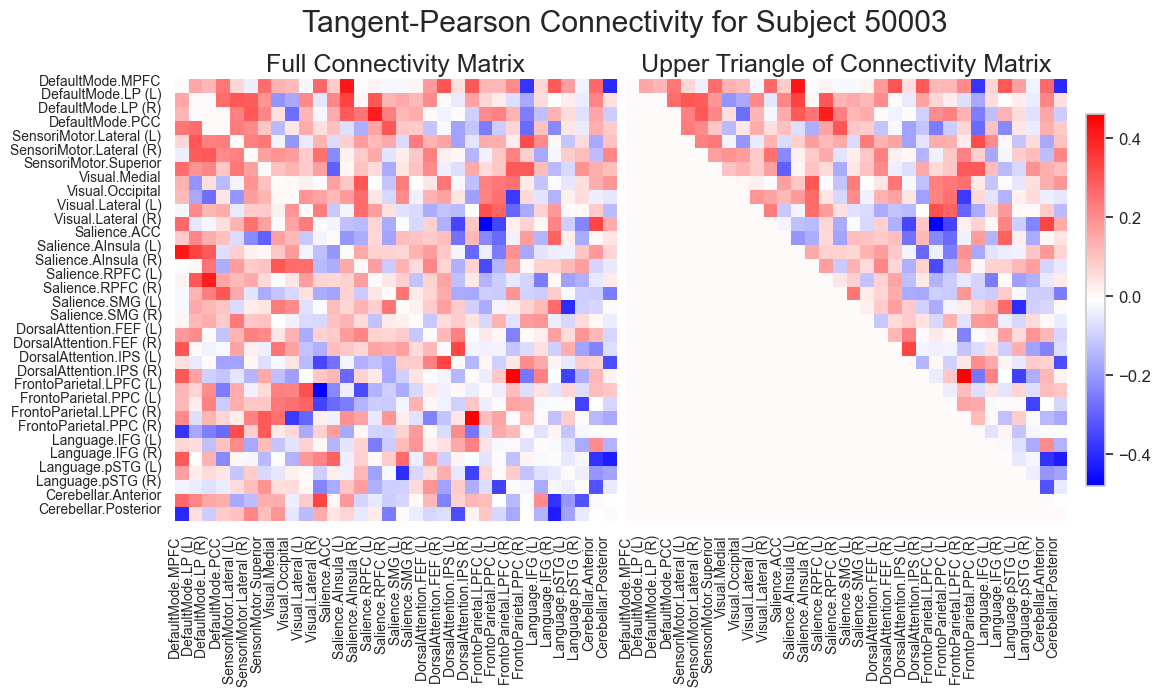

In [ ]:
from visualization import plot_connectivity_matrix

sub_idx = 0
sub_id = phenotypes.loc[0, "SUB_ID"]

title = f"Tangent-Pearson Connectivity for Subject {sub_id}"

fig, ax = plot_connectivity_matrix(
    fc[sub_idx], rois, figsize=(12, 6), annotate=True, cmap="bwr", title=title
)
fig.show(warn=False)

The heatmap above displays the **functional connectivity (FC) matrix** for **Subject 50003**, computed using the **Tangent-Pearson** method. The matrix represents pairwise relationships between different brain regions of interest (ROIs) based on their time-series similarity.

- **Left panel – Full Connectivity Matrix**:  
  A symmetric matrix where each entry represents the strength and direction of FC between two ROIs.  
  - **Red values** indicate positive connectivity.  
  - **Blue values** indicate negative connectivity.  
  - The matrix is symmetric because the connectivity from region A to B is equal to that from B to A.

- **Right panel – Upper Triangle of the Matrix**:  
  To avoid redundancy due to symmetry, only the **upper triangular portion** of the matrix (excluding the diagonal) is shown.  
  This representation is commonly used in machine learning pipelines to **vectorize the FC matrix** for classification or regression tasks, significantly reducing the number of features from `n*n` to `n*(n-1)/2`, where `n` is the number of ROIs. However, the feature size increase will remain `O(n^2)` as the number of ROIs increases.

- **Colorbar**:  
  Indicates the range of connectivity values, with stronger connections lying at the extremes of red and blue.

This representation is widely used in neuroimaging studies for subject-level modeling, feature extraction, and biomarker discovery.

::::{exercise}
:label: find-roi-count

How many ROIs are defined in the FC matrix?

:::{hint}
:class: dropdown

- In Python, the length of arrays like lists and tuples can be
found using `len(array)`.

- The `rois` variable is an array containing the label for each
available ROI.
:::
::::

Next, we want to inspect the phenotypic information provided in **ABIDE dataset**.

In [ ]:
display(phenotypes.sample(5, random_state=cfg.RANDOM_STATE))

,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
15,50019,17,50019,PITT,Pitt_0050019,1,1,27.8100,1,R,...,NaN,OK,NaN,fail,ic-occipital_parietal,OK,NaN,OK,NaN,1
256,50343,267,50343,UM_1,UM_1_0050343,2,0,13.8000,2,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0
273,50360,284,50360,UM_1,UM_1_0050360,2,0,13.9000,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
623,50987,678,50987,NYU,NYU_0050987,1,1,8.5600,1,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
336,50441,350,50441,USM,USM_0050441,2,0,27.5975,1,NaN,...,NaN,maybe,skull-striping fail;,OK,NaN,OK,NaN,OK,NaN,1


As we can see, there is a wide range of phenotypic information available for each subject ranging from patient descriptors such as site (`SITE_ID`), diagnostic group (`DX_GROUP`), and age at scan (`AGE_AT_SCAN`), to quality control metrics for individual scans (e.g., columns starting with `qc`).

::::{exercise}
:label: find-number-of-phenotypes

How many phenotypic variables are available in the ABIDE dataset?
::::

We also want to know how the phenotypes are distributed, we can visualize it with count and histogram plot for categorical and continuous variable respectively. Following Kunda et al. (2022), we mainly focused on the distribution of site, gender, handedness, eye status, age, and FIQ.

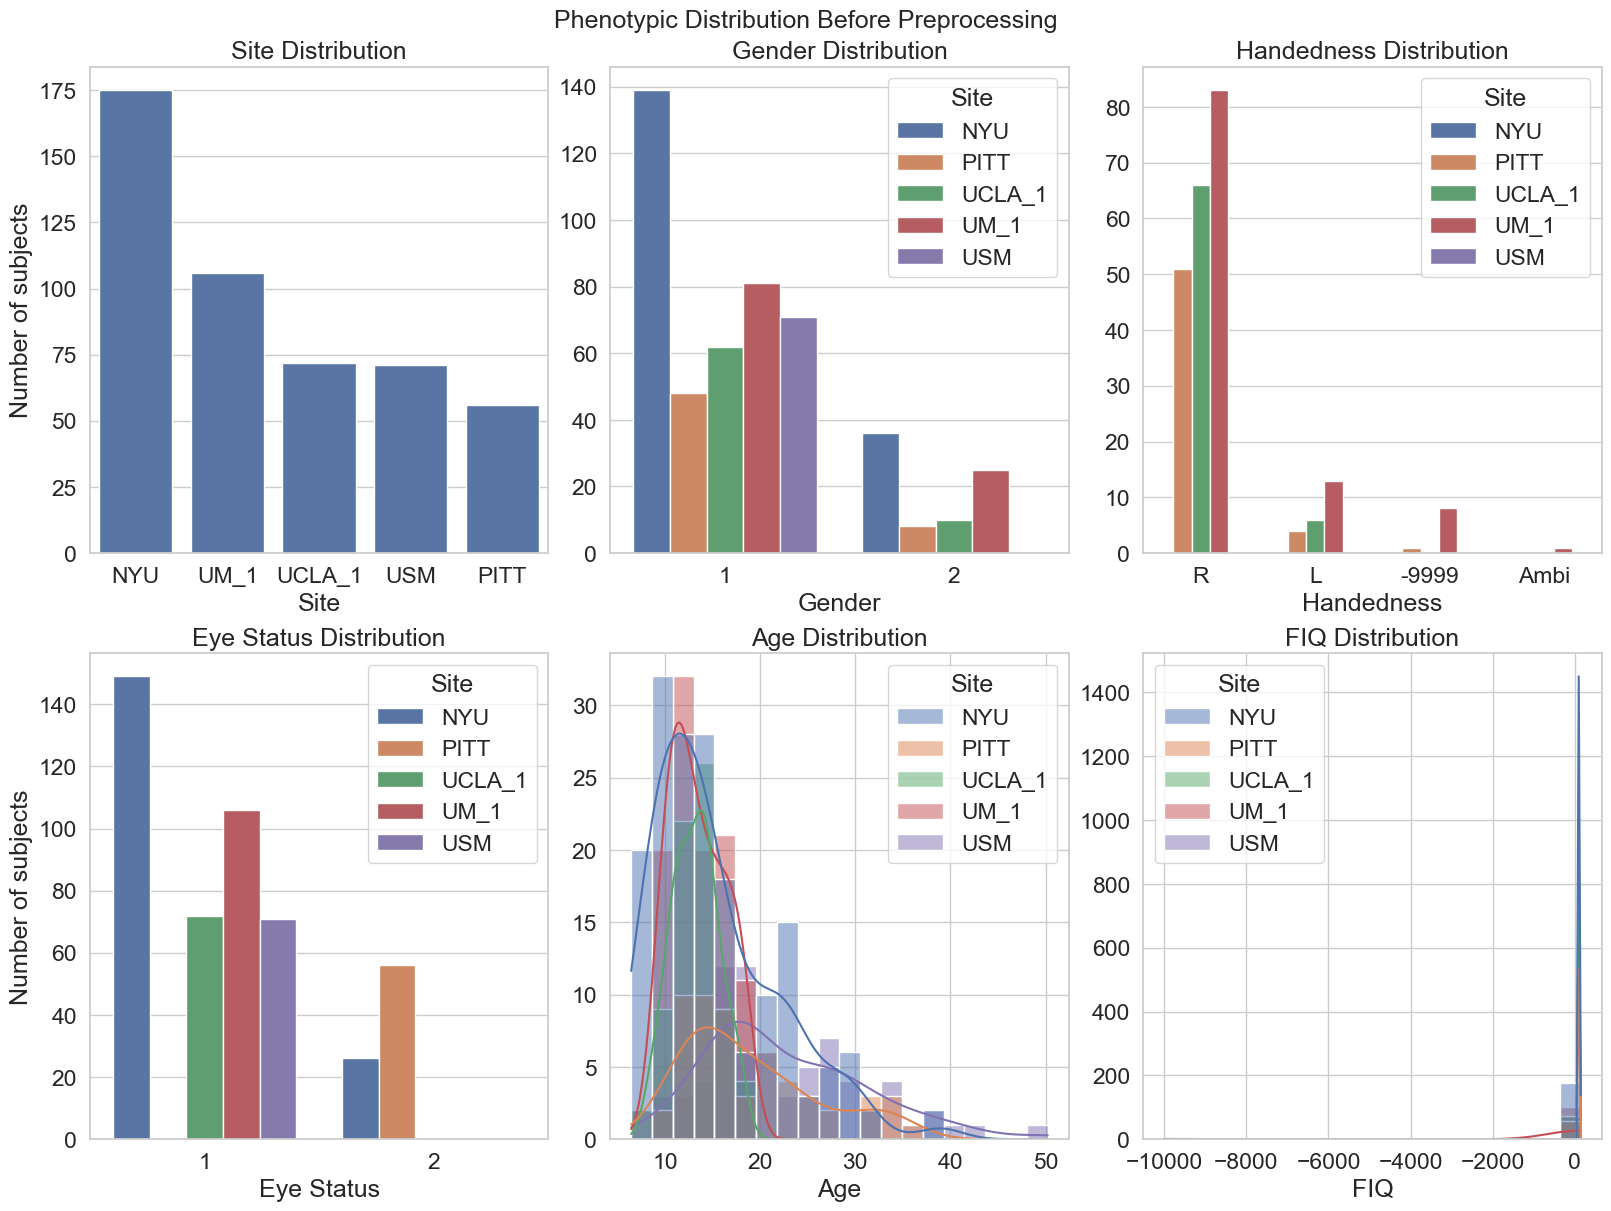

In [ ]:
from visualization import plot_phenotypic_distribution

# Prepare phenotypic values for plotting
values = [
    ("Site", phenotypes["SITE_ID"], "category"),
    ("Gender", phenotypes["SEX"], "category"),
    ("Handedness", phenotypes["HANDEDNESS_CATEGORY"], "category"),
    ("Eye Status", phenotypes["EYE_STATUS_AT_SCAN"], "category"),
    ("Age", phenotypes["AGE_AT_SCAN"], "double"),
    ("FIQ", phenotypes["FIQ"], "double"),
]

# Plot phenotypic distribution
fig, _ = plot_phenotypic_distribution(
    *values,
    title="Phenotypic Distribution Before Preprocessing",
    ncols=3,
    figsize=(16, 12),
)
fig.show(warn=False)

There are couple insights we can infer from the plots:

- **Site Distribution**: The majority of subjects were collected at the NYU site, followed by UM_1 and UCLA_1, with fewer subjects from USM and PITT. This site imbalance may influence downstream analysis and should be accounted for via harmonization or stratification.

- **Gender Distribution**: Most subjects are male (`1`), with female (`2`) subjects being notably underrepresented across all sites.

- **Handedness Distribution**: While right-handed (`R`) subjects dominate the dataset, a noticable number of entries are marked with `-9999`, indicating **missing or invalid values**. This missingness is not uniformly distributed across sites and could introduce bias or noise in analysis if not handled properly.

- **Eye Status Distribution**: Most scans were acquired with eyes open (`1`). The eye status data appears fairly consistent across sites, although the number of missing or less common conditions is minimal.

- **Age Distribution**: The age of subjects spans from around 5 to 50 years, with a strong skew toward younger participants. This distribution is typical for developmental neuroimaging datasets like ABIDE, and care must be taken to control for age in any group comparison.

- **FIQ (Full-Scale IQ) Distribution**: The histogram shows an **extreme skew**, with a dense peak at around zero, again reflecting a noticable number of **missing values** denoted by `-9999`. These missing FIQ scores could severely distort any statistical modeling involving cognitive performance unless they are imputed or excluded appropriately.

## 🛠️ Data Preprocessing

Before modeling, we need to preprocess the phenotypic variables to ensure they are in a usable format. This includes handling missing values, encoding categorical variables, and optionally standardizing continuous ones.

**Categorical Variables**

The following categorical phenotypes are included and will be **one-hot encoded** for modeling:

- `SITE_ID`
- `SEX`
- `HANDEDNESS_CATEGORY`
- `EYE_STATUS_AT_SCAN`

These variables are first mapped to descriptive labels using the provided `MAPPING` dictionary:

- `SEX`: `{1 → MALE, 2 → FEMALE}`
- `HANDEDNESS_CATEGORY`: Includes various representations unified into:
  - `"RIGHT"` (including missing values and `-9999`)
  - `"LEFT"`
  - `"AMBIDEXTROUS"` (e.g., `"Mixed"`, `"L->R"`, `"Ambi"`)
- `EYE_STATUS_AT_SCAN`: `{1 → OPEN, 2 → CLOSED}`

**Continuous Variables**

The following continuous phenotypes will be optionally **standardized**:

- `AGE_AT_SCAN`
- `FIQ`

We will explain the available options for standardizing these phenotypes in more detail down below.

**Handling Missing Values**

Missing values are handled with the following assumptions and imputation strategies:

- `HANDEDNESS_CATEGORY`: Missing entries (`-9999` or `NaN`) are imputed as `"RIGHT"`.
- `FIQ`: Missing scores (`-9999`) are imputed with a default value of `100`.

These choices ensure that the downstream models can operate without interruption while maintaining reasonable assumptions based on domain knowledge.

**Target Variable Encoding**

The diagnostic group `DX_GROUP` is used to define the target label for classification:

- `CONTROL` → `0`
- `ASD` → `1`

This binary label is suitable for supervised learning tasks focused on ASD detection.

To do this, the `preprocess_phenotypic_data` function handles this functionality for us.
The main arguments for `preprocess_phenotypic_data` include:

- **`data`**:  
  A DataFrame containing the phenotypic information for each subject. Must include all selected phenotypes such as `SEX`, `AGE_AT_SCAN`, `FIQ`, `HANDEDNESS_CATEGORY`, `EYE_STATUS_AT_SCAN`, and `DX_GROUP`.  
  - *Type:* `pd.DataFrame` of shape `(n_subjects, n_phenotypes)`  
  - *Required*

- **`standardize`**:  
  Whether to standardize continuous variables (`AGE_AT_SCAN` and `FIQ`). This helps remove scale-related bias before modeling.  
  - Available options:
    - `False`: No standardization (raw values retained)  
    - `True` or `"all"`: Standardize across all subjects  
    - `"site"`: Standardize within each acquisition site  
  - *Default:* `False`

- **`one_hot_encode`**:  
  Whether to one-hot encode categorical variables (`SITE_ID`, `SEX`, `HANDEDNESS_CATEGORY`, `EYE_STATUS_AT_SCAN`). This is typically used when feeding the data into machine learning models.  
  - *Type:* `bool`  
  - *Default:* `True`

The function returns the following:

- **`labels`** (`array-like`):  
  The encoded diagnostic labels derived from `DX_GROUP`.  
  - `0`: CONTROL  
  - `1`: ASD  
  - *Shape:* `(n_subjects,)`

- **`sites`** (`array-like`):  
  Site identifiers corresponding to each subject, useful for site-wise stratification or harmonization.  
  - *Shape:* `(n_subjects,)`

- **`phenotypes`** (`pd.DataFrame`):  
  The cleaned and processed phenotype DataFrame with missing values imputed, categorical variables mapped (and optionally one-hot encoded), and continuous variables optionally standardized.  
  - *Shape:* `(n_subjects, n_selected_phenotypes)`  
  - *Note:* The selected phenotypes include:
    - `SITE_ID`
    - `SEX`
    - `AGE_AT_SCAN`
    - `FIQ`
    - `HANDEDNESS_CATEGORY`
    - `EYE_STATUS_AT_SCAN`

In [ ]:
from preprocess import preprocess_phenotypic_data

labels, sites, phenotypes = preprocess_phenotypic_data(
    phenotypes, cfg.PHENOTYPE.STANDARDIZE
)

After preprocessing, we want to observe how the encoding, imputation, and standardization affected the phenotypes.

In [ ]:
display(phenotypes.sample(5, random_state=cfg.RANDOM_STATE))

,AGE_AT_SCAN,FIQ,SITE_ID_NYU,SITE_ID_PITT,SITE_ID_UCLA_1,SITE_ID_UM_1,SITE_ID_USM,SEX_FEMALE,SEX_MALE,HANDEDNESS_CATEGORY_AMBIDEXTROUS,HANDEDNESS_CATEGORY_LEFT,HANDEDNESS_CATEGORY_RIGHT,EYE_STATUS_AT_SCAN_CLOSED,EYE_STATUS_AT_SCAN_OPEN
SUB_ID,,,,,,,,,,,,,,
50019,1.290443,-0.839198,False,True,False,False,False,False,True,False,False,True,True,False
50343,0.138027,1.391179,False,False,False,True,False,True,False,False,False,True,False,True
50360,0.172863,0.607927,False,False,False,True,False,False,True,False,False,True,False,True
50987,-1.023250,-0.368529,True,False,False,False,False,False,True,False,False,True,False,True
50441,0.591718,1.014467,False,False,False,False,True,False,True,False,False,True,False,True


Now we can see that the number of phenotypes are now reduced, the continuous and categorical variables are now standardized and one-hot encoded respectively.

::::{exercise}
:label: find-number-of-phenotypes-after-preprocess

How many phenotypes are there once we have preprocessed the phenotypes?

:::{hint}
:class: dropdown

- In `pandas`, executing `pd.DataFrame.shape` outputs a `tuple` containing
`(num_rows, num_columns)`.

- The `phenotypes` variable is a `pd.DataFrame` type.
:::
::::

::::{exercise}
:label: understanding-one-hot-encoding

We have seen the preprocessed phenotypes and noted that the categorical
variables have been one-hot-encoded.

Given your observation, what does one-hot encoding do to the categorical variables?
::::

We also want to check how the phenotypes are distributed after we preprocess it.

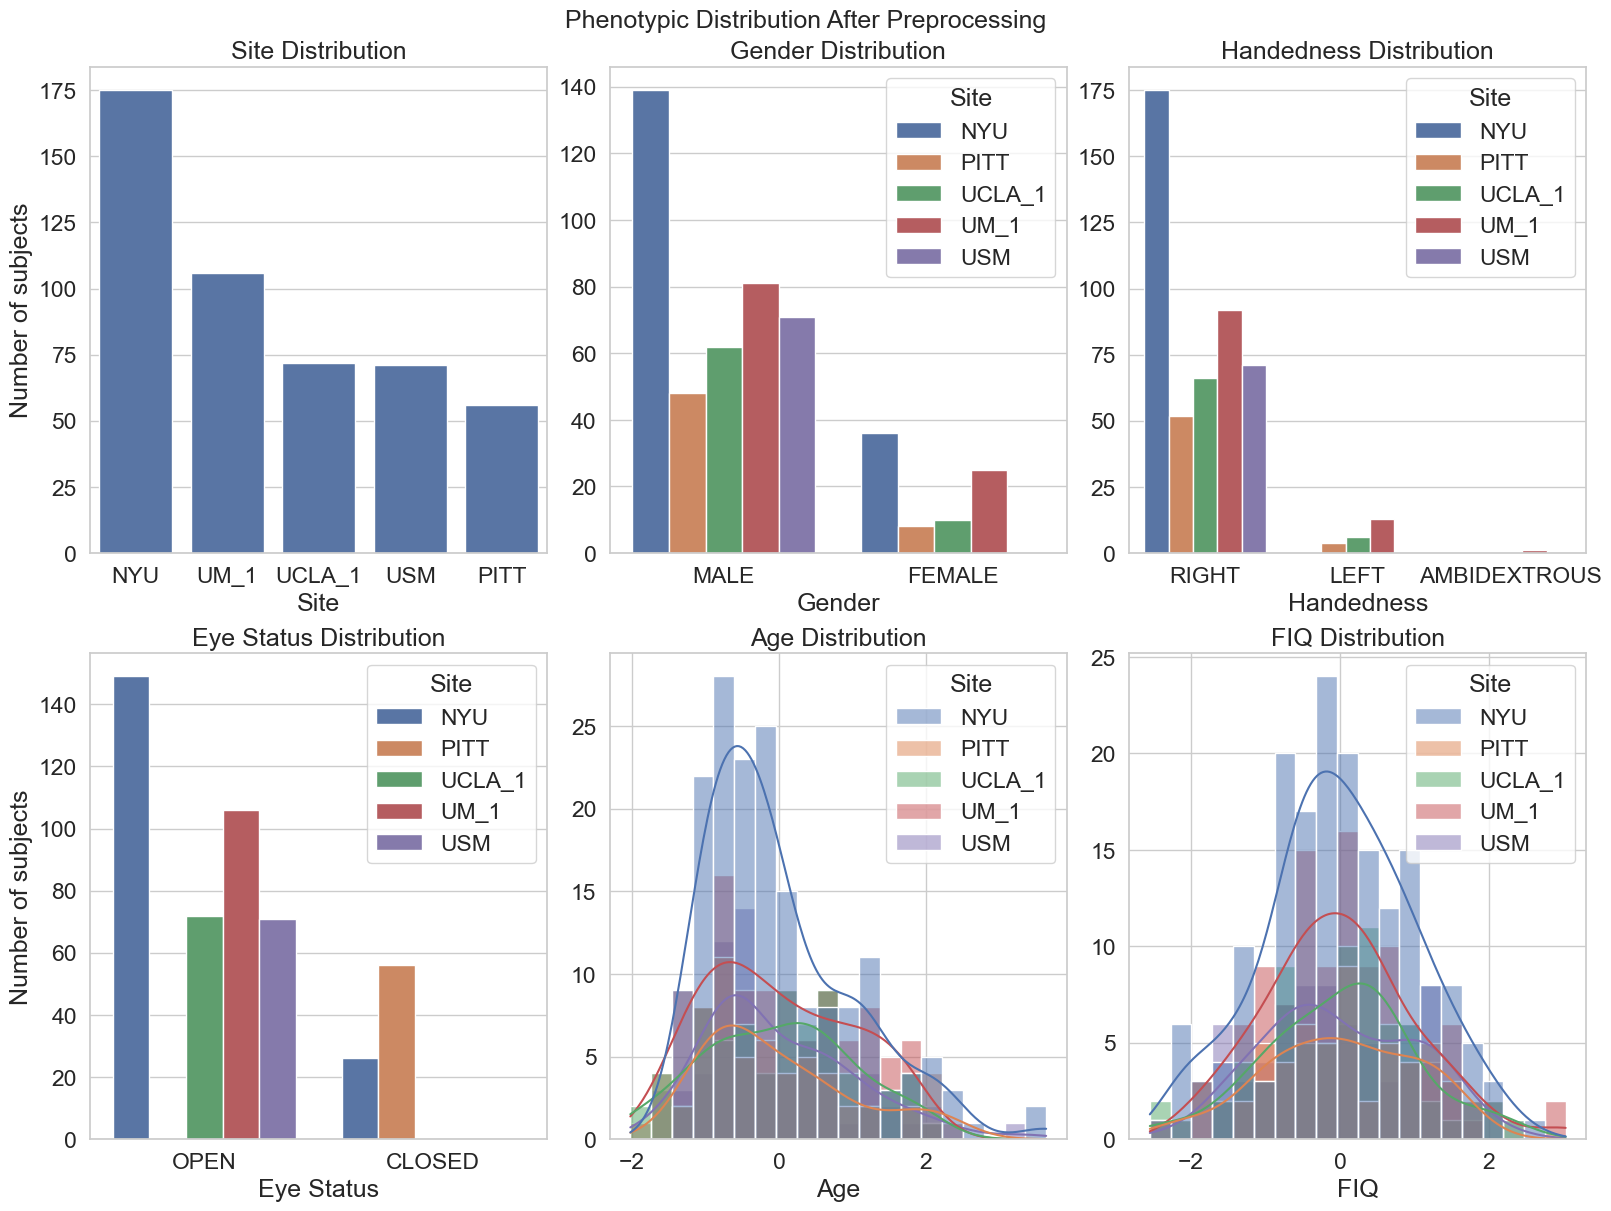

In [ ]:
from visualization import plot_phenotypic_distribution


# Mapping from column names to readable labels
MAPPING = {
    "SEX": "Gender",
    "HANDEDNESS_CATEGORY": "Handedness",
    "EYE_STATUS_AT_SCAN": "Eye Status",
    "SITE_ID": "Site",
    "AGE_AT_SCAN": "Age",
    "FIQ": "FIQ",
}

# Initialize list with site information
values = [("Site", sites, "category")]

# Iterate over relevant phenotype variables
for key, label in MAPPING.items():
    if key == "SITE_ID":
        continue

    # Direct numeric columns
    if key in ["AGE_AT_SCAN", "FIQ"]:
        values.append((label, phenotypes[key], "double"))
        continue

    # One-hot encoded categorical variables
    one_hot_cols = phenotypes.filter(like=key)
    if one_hot_cols.empty:
        continue

    # Decode one-hot encoding by extracting the max value index
    decoded = one_hot_cols.idxmax(axis=1).str.replace(f"{key}_", "")
    values.append((label, decoded, "category"))

# Plot the distributions
fig, _ = plot_phenotypic_distribution(
    *values,
    title="Phenotypic Distribution After Preprocessing",
    ncols=3,
    figsize=(16, 12),
)
fig.show(warn=False)

We can see that we can interpret the phenotypes much clearer now, as we can infer that:

- **Site Distribution**: The largest number of subjects were recruited from the NYU site, followed by UM_1 and UCLA_1. Fewer samples came from USM and PITT. This site imbalance highlights the need for harmonization techniques or stratified sampling to mitigate site effects in downstream analyses.

- **Gender Distribution**: A clear male predominance is observed across all sites, consistent with the known sex bias in autism prevalence. Female participants are underrepresented, which should be considered when modeling gender-specific effects.

- **Handedness Distribution**: Right-handed individuals dominate the dataset. While a small number of left-handed and ambidextrous subjects exist, the most striking feature is the absence of missing values (unlike the original dataset where `-9999` was present). If this reflects post-cleaning, the missing data may have been handled or excluded.

- **Eye Status Distribution**: Most subjects were scanned with eyes open. The distribution is relatively consistent across sites, with minimal representation of closed-eye scans.

- **Age Distribution**: Subjects are predominantly young, with a noticeable peak near the lower bound of the age range. This skew toward childhood and adolescence is typical of ABIDE and reflects its focus on developmental stages in autism.

- **FIQ (Full-Scale IQ) Distribution**: The FIQ scores are approximately normally distributed after standardization. Unlike raw scores (which often include invalid values such as `-9999`), the plot suggests cleaned or imputed data. Despite this, care must be taken when interpreting cognitive performance due to potential imputation bias or loss of outlier information.

# 🧶 Model Definition

**PyKale** provides flexible pipelines for modeling interdisciplinary problems. In our case, the primary objective is to develop a **robust yet interpretable model** capable of effectively integrating multi-site data.

We leverage the `kale.pipeline.multi_domain_adapter.AutoMIDAClassificationTrainer` (or simply `Trainer`), which encapsulates the domain adaptation method [**Maximum Independence Domain Adaptation (MIDA)**](https://ieeexplore.ieee.org/document/7815350). This trainer integrates domain adaptation with classification by allowing the user to specify any `scikit-learn`-compatible linear classifier for prediction, offering a convenient way to construct powerful and flexible pipelines.

In the following sections, we first describe the **cross-validation split** strategy used in this tutorial, followed by an explanation of the **embedding extraction** and **prediction** methods.

## 🤼 Cross-Validation Split

The choice of cross-validation strategy can significantly impact how can we evaluate of a model's robustness and generalizability, especially when dealing with multi-site or grouped data.

:::{figure} figures/split-comparison.png
Illustrative comparison between n-repeated stratified k-fold and leave p-groups out
:::

:::{admonition} Legend Description
- White boxes: Training samples  
- Colored boxes: Test samples (color indicates group)  
- `+` / `−`: Binary class labels  
- Group 1 (red), Group 2 (blue), Group 3 (yellow)
:::

The figure above compares two common validation strategies which we will consider for this tutorial:

- **n-Repeated Stratified k-Fold (SKF)**:  
  This method ensures that each fold maintains the original label distribution (e.g., equal proportion of `+` and `−` classes). However, it does **not** guarantee that data from the same group (e.g., site, subject, scanner) are kept together, potentially leading to data leakage if the same group appears in both train and test splits.

- **Leave p-Groups Out (LPGO)**:  
  This method preserves the **group structure** by leaving out entire groups during each iteration. It is particularly suited for evaluating generalization to unseen sites or subjects, as it avoids group leakage. However, it may result in imbalanced label distributions in each fold.

Each method serves a different purpose: stratified k-fold is ideal when label balance is critical, while leave-p-groups-out is better for assessing model robustness under domain shift or site variability. Realistically, LPGO is preferable given real data will most likely not have the same distribution as a model's training data.

::::{exercise}
:label: find-total-models-produced

Consider we evaluate a model using SKF with two repetition and five folds or LPGO with ten groups with one group left out for testing, we will need to train a total of ten models. If we evaluate a model using:
- SKF with five repetition and ten folds
- LPGO with five groups and two groups left out for testing

How many models we have to train for each cases?

:::{hint}
:class: dropdown
For LPGO, given `m` total groups and `p` left out groups, consider it as a combinatorial problem.
:::
::::

In this tutorial, we specify the following arguments for cross-validation:
- **`split`**: Defines the cross-validation strategy.
  - Available options: 
    - `"skf"`: Stratified K-fold to maintain label balance in each fold.
    - `"lpgo"`: Leave p-groups out to evaluate generalization across sites by holding out entire groups (e.g., imaging sites).
  - *Default:* `"skf"`

- **`num_folds`**: The number of folds for `"skf"` or the number of groups to leave out in `"lpgo"`.
  - *Default:* `10`

- **`num_repeats`**: The number of times the k-fold procedure is repeated to obtain more stable estimates (ignored with `"lpgo"`).
  - *Default:* `5`

- **`random_state`**: Seed for random number generators for reproducibility.
  - *Default:* `None`

In [ ]:
from sklearn.model_selection import LeavePGroupsOut, RepeatedStratifiedKFold

# Define the default cross-validation strategy:
# Repeated stratified k-fold maintains class distribution across folds and supports multiple repetitions
cv = RepeatedStratifiedKFold(
    # Number of stratified folds
    n_splits=cfg.CROSS_VALIDATION.NUM_FOLDS,
    # Number of repeat rounds
    n_repeats=cfg.CROSS_VALIDATION.NUM_REPEATS,
    # Ensures reproducibility, intentionally set to the seed to have the same splits across runs
    random_state=cfg.RANDOM_STATE,
)

# Override with leave-p-proups-out if specified
# This strategy holds out `p` unique groups (e.g., sites) per fold, enabling group-level generalization
if cfg.CROSS_VALIDATION.SPLIT == "lpgo":
    # Use group-based CV for domain adaptation or site bias evaluation
    cv = LeavePGroupsOut(cfg.CROSS_VALIDATION.NUM_FOLDS)

## 📥 Embedding Extraction

**Domain adaptation** aims to reduce distributional discrepancies between datasets collected under different conditions (e.g., sites, scanners, protocols). This helps ensure that the learned representations generalize across domains.

**MIDA** was originally proposed by [Yan et al. (2017)](https://ieeexplore.ieee.org/document/7815350) in *IEEE Transactions on Cybernetics* to reduce time-varying drift in sensors, using domain features such as device label and acquisition time.

Kunda et al. (2022) extended MIDA for neuroimaging studies, enabling multi-domain adaptation for **multi-site data integration**.

PyKale includes a `scikit-learn`-style implementation of MIDA in `kale.embed.factorization.MIDA`, adopting a similar interface to `KernelPCA` to ensure interoperability, extensive customization, and ease of use.

## 📡 Prediction Methods

To maintain compatibility and user-friendliness, PyKale supports **linear classifiers** from `scikit-learn`, including:

- **Logistic Regression (LR)**
- **Support Vector Machines (SVM)**
- **Ridge Classifier (Ridge)**

These models can be selected easily by passing the appropriate string identifier, streamlining experimentation with different classifiers.

Linear classifiers are particularly suitable in this context due to their **inherent interpretability**. Its coefficients can be directly inspected to understand the contribution of each feature to the prediction.

## 🏎️ Baseline and Proposed Model

We define several model configurations used for classification. Each model shares the same base classifier but differs in how domain adaptation is applied:

- **Baseline**: A standard model trained directly on functional connectivity features without domain adaptation.
- **Site Only**: A domain-adapted model that uses site labels as the adaptation factor to reduce site-specific bias.
- **All Phenotypes**: An extended domain-adapted model that incorporates multiple phenotypic variables (e.g., age, sex, handedness) to further reduce inter-site variability.

We also specify the hyperparameter search strategy and other training parameters for each configuration, including:

- **`classifier`**: The base model used for classification.
  - Available options:
    - `"lda"`: Linear Discriminant Analysis
    - `"lr"`: Logistic Regression
    - `"linear_svm"`: Linear Support Vector Machine
    - `"svm"`: Kernel Support Vector Machine
    - `"ridge"`: Ridge Classifier (L2-regularized linear model)
    - `"auto"`: Automatically selects an appropriate model based on data characteristics.
  - *Default:* `"lr"`

- **`param_grid`**: The hyperparameter grid used for both the classifier and the MIDA domain adapter.
  - To specify MIDA’s parameters, each key in the grid must be prefixed with `domain_adapter__` (e.g., `domain_adapter__mu`).
  - For classifier parameters, no prefix is needed.
  - If `param_grid` is set to `None`, PyKale will use its default grid, which spans a broad hyperparameter search space. While this may maximize performance, it significantly increases training time.
  - Therefore, it is **not recommended** to use `param_grid=None` in combination with `search_strategy='grid'`.
  - *Default:* `None`

- **`nonlinear`**: Whether to apply non-linear transformations (non-interpretable).
  - *Type:* `boolean`
  - *Default:* `False`

- **`search_strategy`**: The hyperparameter search method.
  - Available options:
    - `"random"`: Randomly search over finite iterations.
    - `"grid"`: Search over all possible combinations.
  - *Default:* `"random"`

- **`num_search_iterations`**: The number of hyperparameter combinations to evaluate in randomized search.
  - *Default:* `1,000`

- **`num_solver_iterations`**: The maximum number of iterations allowed for solver convergence.
  - *Default:* `1,000,000`

- **`scoring`**: A list of performance metrics used during cross-validation.
  - Available options:
    - `"accuracy"`: Accuracy
    - `"precision"`: Precision
    - `"recall"`: Recall
    - `"f1"`: F1-Score
    - `"roc_auc"`: Area Under ROC Curve (AUROC)
    - `"matthews_corrcoef"`: Matthews Correlation Coefficient (MCC)
  - *Default:* `["accuracy", "roc_auc"]`

- **`refit`**: The metric used to refit the best model after hyperparameter tuning.
  - *Default:* `"accuracy"`

- **`num_jobs`**: The number of CPU cores used for training and hyperparameter search.
  - Set to `k` to use `k` CPU cores, `-1` for all CPU cores, `-k` for all but `k` CPU cores.
  - *Default:* `1`

- **`pre_dispatch`**: Controls job pre-dispatching for parallel execution.
  - *Default:* `"2*n_jobs"`

- **`verbose`**: Controls verbosity of training output.
  - *Default:* `0`

- **`random_state`**: Seed for random number generators for reproducibility.
  - *Default:* `None`

In [ ]:
from sklearn.base import clone
from kale.pipeline.multi_domain_adapter import AutoMIDAClassificationTrainer as Trainer

from parsing import parse_param_grid

# Configuration with cv and random_state/seed included
trainer_cfg = {k.lower(): v for k, v in cfg.TRAINER.items() if k != "PARAM_GRID"}
trainer_cfg = {**trainer_cfg, "cv": cv, "random_state": cfg.RANDOM_STATE}

# Initialize dictionary for different trainers
trainers = {}

# Create a baseline trainer without domain adaptation (MIDA disabled)
param_grid = parse_param_grid(cfg.TRAINER.PARAM_GRID, "domain_adapter")
trainers["baseline"] = Trainer(use_mida=False, param_grid=param_grid, **trainer_cfg)

# Create a trainer with MIDA enabled, using site labels as domain adaptation factors
param_grid = parse_param_grid(cfg.TRAINER.PARAM_GRID)
trainers["site_only"] = Trainer(use_mida=True, **trainer_cfg)

# Clone the 'site_only' trainer to create 'all_phenotypes' trainer
# This enables reusing the same training configuration, while modifying only the input domain factors
trainers["all_phenotypes"] = clone(trainers["site_only"])

# 🏃 Model Training

The `Trainer` automatically handles model training and hyperparameter tuning based on the specified cross-validation strategy. To initiate training, simply call the `fit(...)` method, which accepts the following arguments:

- `x`: The input features used for training and tuning the model.

- `y`: The target labels corresponding to each sample.

- `groups`: Group identifiers for each sample, used specifically in group-aware cross-validation methods such as Leave-p-Groups-Out (LPGO).

- `group_labels`: Additional metadata or domain features describing each sample (e.g., phenotypes, one-hot encoded site indicators) used by the domain adaptation method.

This interface allows seamless integration of domain information and supports robust validation across multi-site datasets.

As noted earlier, we evaluate three model variants:

- For the **baseline** model, no additional `group_labels` are required, as domain adaptation is not applied.
- The **site only** and **all phenotypes** models **do require** `group_labels` to be specified in order to enable domain adaptation using site or phenotypic information.

Given that we have already preprocessed the phenotypic data and extracted site labels, we can pass the appropriate `group_labels` during training:

- Use `sites` for the **site only** model.
- Use the full `phenotypes` data (including one-hot encoded site and demographic features) for the **all phenotypes** model.

This demonstrates that the `Trainer` provides flexible control over the use of **MIDA**, allowing users to choose whether or not to incorporate domain adaptation based on the available metadata and the specific goals of their analysis.

In [ ]:
import pandas as pd
from tqdm import tqdm

# Define common training arguments for all models: features (X), labels (y), and group info (sites)
fit_args = {"x": fc, "y": labels, "groups": sites}

cv_results = {}
for model in (pbar := tqdm(trainers)):
    args = clone(fit_args, safe=False)
    if model == "site_only":
        args["group_labels"] = sites
    if model == "all_phenotypes":
        args["group_labels"] = phenotypes

    pbar.set_description(f"Fitting {model} model")
    trainers[model].fit(**args)
    cv_results[model] = pd.DataFrame(trainers[model].cv_results_)

Fitting all_phenotypes model: 100%|██████████| 3/3 [00:59<00:00, 19.89s/it]


Once the models are simultaneously trained and tuned, the cross-validation results are stored in the `cv_results_` attribute. These results are automatically sorted according to the metric specified in the `refit` argument.

The `cv_results_` object contains comprehensive information, including:
- The hyperparameter configurations explored during tuning.
- Performance scores for each split.
- Aggregated statistics such as the mean and standard deviation across folds.

This allows for detailed inspection and comparison of model performance across different hyperparameter settings.

If we are only interested in a single evaluation metric, we can use the `best_score_` attribute to retrieve the best average performance across all splits based on that metric.

To facilitate comparison across models, we aggregate each model’s `cv_results_` into a `dict` of `pd.DataFrame` objects. These can then be compiled into a summary table that highlights the best-tuned performance for each of the three evaluated models.

::::{exercise}
:label: find-the-aggregate-in-cv-results
Can you mention what are the available aggregates for each metrics found in `cv_results_`?

:::{hint}
:class: dropdown
You can inspect `cv_results_` or `cv_results[model]` just like accessing `phenotypes`.
:::
::::

## 📈 Evaluation

After training and tuning the models, we evaluate the performance of the three model configurations using **accuracy** as the primary metric for comparison.

We compile the top-performing scores from cross-validation for each model, allowing us to assess the effectiveness of different domain adaptation strategies. By comparing models with and without domain adaptation, we can examine the impact of incorporating **site** and **phenotypic** information on multi-site autism classification performance.

This analysis highlights which configurations generalize best across heterogeneous imaging sites.

In addition, we report performance from an experiment using **2-repeated stratified 5-fold cross-validation (SKF)**, which can be run by loading the configuration file at `experiments/skf/base.yml`. As expected, the performance differences are less pronounced in this setting. This is likely because blending data from different sites maintains label distribution but does **not** reflect a realistic evaluation of generalization under domain shift, a scenario encountered when deploying models to unseen sites.

| Model              | Accuracy           | AUROC             |
|:------------------|:------------------:|:-----------------:|
| **Baseline**       | 0.6719 ± 0.0491    | 0.7332 ± 0.0427   |
| **Site Only**      | 0.6771 ± 0.0525    | 0.7381 ± 0.0483   |
| **All Phenotypes** | 0.6750 ± 0.0541    | 0.7387 ± 0.0481   |

The key question now is: **Does domain adaptation actually improve predictive performance under a leave-one-group-out setting, where generalization to unseen sites is critical?**

In [ ]:
from parsing import compile_results

# Compile the cross-validation results into a summary table,
# sorting by the model with the highest test accuracy across CV folds
compiled_results = compile_results(cv_results, "accuracy")

# Display the compiled results DataFrame (models as rows, metrics as formatted strings)
display(compiled_results)

,Accuracy,AUROC
Model,,
Baseline,0.6730 ± 0.0476,0.7288 ± 0.0527
Site Only,0.6995 ± 0.0504,0.7621 ± 0.0426
All Phenotypes,0.6933 ± 0.0405,0.7538 ± 0.0411


Turns out, domain adaptation indeed helps when evaluated under the **leave-one-group-out (LPGO)** setting.

We observe a consistent performance improvement when incorporating site and phenotypic information:

- The **Site Only** model achieves the highest accuracy and AUROC, indicating that accounting for site differences is beneficial for generalization.
- The **All Phenotypes** model also outperforms the **Baseline**, suggesting that additional phenotypic features contribute useful domain information, although the marginal gain over site alone is smaller.
- The **Baseline** model, which does not use domain adaptation, performs worst, highlighting the challenge of multi-site variability when no adaptation is applied.

These results demonstrate the effectiveness of domain adaptation in improving model generalization across imaging sites, especially in scenarios where each site may exhibit different data distributions.

# 🕶️ Interpretation

We interpret the trained models by analyzing the learned weights associated with functional connectivity features. Specifically, we extract the top-weighted ROI pairs that contribute most to the classification decision.

These weights are visualized using a **connectome plot**, which helps reveal the brain region interactions that are most informative for distinguishing individuals with autism from neurotypical controls. This enhances the **interpretability** of the model and may offer insights into **neurobiological patterns** relevant to autism.

To support this, **PyKale** extends `nilearn`'s `plot_connectome` through the utility `kale.interpret.visualize.visualize_connectome`. This enhanced version improves interpretability by:
- Adding annotations for each ROI.
- Visualizing only the top-weighted connections between regions, making the plot more focused and informative.

This visualization aids both in model transparency and in deriving neuroscientific interpretations from machine learning outputs.

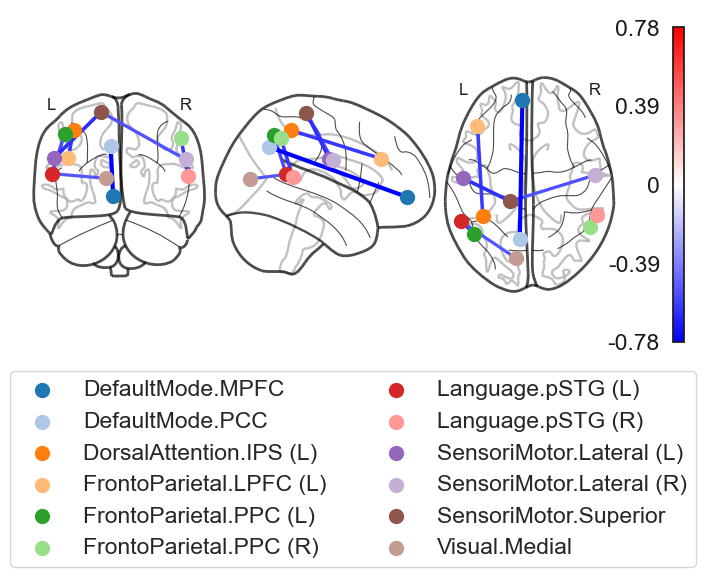

In [ ]:
import numpy as np
from kale.interpret.visualize import visualize_connectome

# Fetch model with best performance
best_model = max(cv_results, key=lambda m: trainers[m].best_score_)
# Fetch coefficients to visualize feature importance
coef = trainers[best_model].coef_.ravel()
# check if coef != features, assumes augmented features with phenotypes/sites
if coef.shape[0] != fc.shape[1]:
    coef, _ = np.split(coef, [fc.shape[1]])

# Visualize the coefficients as a connectome plot
proj = visualize_connectome(
    coef,
    rois,
    coords,
    1.5 / 100,  # Take top 1.5% of connections
    legend_params={
        "bbox_to_anchor": (3.75, -0.4),  # Align legend outside the plot
        "ncol": 2,
    },
)

# Display the resulting connectome plot
display(proj)

The figure illustrates the **most discriminative ROI-to-ROI functional connections** that differentiate **ASD** (Autism Spectrum Disorder) from **Control** participants.

- **Blue edges** indicate **stronger functional connectivity in Control** subjects.
- **Red edges** (not present in this figure) would indicate **stronger connectivity in ASD**.
- The **color saturation** and **thickness of the edges** reflect the **magnitude of each connection’s discriminative contribution**.

**Key Observations:**

- **Default Mode Network (DMN)**  
  - *DefaultMode.MPFC*, *DefaultMode.PCC*  
  - Connections within the DMN appear attenuated in ASD, consistent with previous literature highlighting reduced **self-referential** and **social cognition** activity.

- **Language Network**  
  - *Language.pSTG (L)* and *Language.pSTG (R)*  
  - We observe reduced interhemispheric and intrahemispheric language connectivity, reinforcing the idea of **language and communication deficits** in ASD.

- **Fronto-Parietal Network**  
  - *FrontoParietal.LPFC (L)*, *FrontoParietal.PPC (L/R)*  
  - Involved in **executive function** and **cognitive flexibility**, both typically altered in ASD.

- **Dorsal Attention Network**  
  - *DorsalAttention.IPS (L)*  
  - Affected connectivity here may reflect difficulties in **external attention modulation**.

- **Sensorimotor System**  
  - *SensoriMotor.Lateral (L/R)*, *SensoriMotor.Superior*  
  - The reduced connectivity could relate to **atypical sensory processing** often observed in individuals with autism.

- **Visual System**  
  - *Visual.Medial*  
  - Suggests altered **visual integration**, which may contribute to perceptual differences in ASD.

**Potential Confounding Networks:**  
It is important to consider that **sensorimotor and visual regions**, while showing discriminative patterns, might also reflect **non-neural confounds** such as **head motion** or **scanner/site-related variability**. These networks are often sensitive to acquisition artifacts and preprocessing differences. However, the inclusion of domain adaptation and site-level harmonization in the modeling pipeline mitigates, but may not fully eliminate such effects. Thus, caution is advised when interpreting sensorimotor and occipital findings solely as autism-specific.

**Summary**:  
This plot highlights a pattern of **reduced connectivity** across core large-scale brain networks—including **DMN**, **language**, and **sensorimotor systems** in ASD. These findings support the hypothesis of disrupted **functional integration** and further validate the use of **connectivity-based biomarkers** in ASD classification.

# 📜 Extra Tasks

**Congratulations!** 🎉

You’ve successfully completed the tutorial! For those eager to explore further or just curious to tweak configurations to enhance performance, we’ve prepared a set of optional tasks. These tasks are designed to encourage experimentation without requiring significant changes to the core code.

---

**🗺️ Task 1**: Explore Different Atlases and FCs *(20–120+ minutes)*

We provide multiple brain atlases and functional connectivity (FC) embeddings to experiment with. You can create a new configuration file or simply uncomment the `cfg.DATASET.ATLAS` option in the configuration section.

**Open-ended questions:**
- Is selecting an appropriate atlas beneficial for building accurate brain disorder diagnosis models?
- If so, how much improvement can we expect from choosing the best atlas?
- Does the best-performing atlas help interpret and localize key ROIs relevant to ASD?
- Or is the choice of atlas less impactful than the choice of functional connectivity method?

---

**📬 Task 2**: Better Phenotypes? *(30–60+ minutes)*

Our results show that using only **site labels** already yields performance improvements. However, we followed Kunda et al. (2022), who used only a subset of the raw phenotype information. There may be additional phenotypic variables that could further improve multi-site integration.

**Questions to explore:**
- Is the **site label alone** truly sufficient for effective multi-site data integration?
- Are there phenotypes with **distinct distributions across sites** that may introduce bias or noise?
- Can incorporating those phenotypes improve performance beyond site-only models?

:::{warning}
Given that there are many missing values as seen previously, this task might be challenging for users who are unfamiliar with Python and `pandas` as it may require manual crafting for encoding or imputation as done in `preprocess_phenotypic_data`.
:::

---

**📊 Task 3**: More Sites → Better Generalization? *(20–60+ minutes)*

With five sites, domain adaptation shows improved generalization under the **leave-one-group-out (LPGO)** setting. This raises new questions:

**Things to consider:**
- Does domain adaptation continue to help as we include **more sites**, or is the benefit limited to fewer-site scenarios?
- Is there a **saturation point** where adding more sites stops improving generalization, or even worsens it?
- Could fewer but more homogeneous sites be better than many heterogeneous ones?

---

These tasks are designed to help you dive deeper into model robustness, generalizability, and interpretability in real-world neuroimaging settings. Feel free to explore, question, and iterate!

Hope you enjoy this tutorial! 😊

# ✍️ Exercise Solutions

:::{solution} find-number-of-samples
:class: dropdown
:label: solution-find-number-of-samples

There are 480 samples found. To find the number of samples,
we can use `len(phenotypes)` which will output 480.
:::

:::{solution} find-roi-count
:class: dropdown
:label: solution-find-roi-count

There are 32 ROIs found. To find the number of ROIs,
we can use `len(rois)` which will output 32.
:::

:::{solution} find-number-of-phenotypes
:class: dropdown
:label: solution-find-number-of-phenotypes

Looking at the dataframe, there are 104 phenotypes based on
the number of columns.
:::

:::{solution} find-number-of-phenotypes-after-preprocess
:class: dropdown
:label: solution-find-number-of-phenotypes-after-preprocess

By calling `phenotypes.shape`, we can inspect the number
of rows and columns. We can see that there are 14 encoded
phenotypes.

If we breakdown the encoded phenotypes:
- Two are continuous variables of `AGE_AT_SCAN` and `FIQ`.
- Five from the encoded `SITE_ID` variable.
- Two from the encoded `SEX` variable.
- Three from the encoded `HANDEDNESS_CATEGORY` variable.
- Two from the encoded `EYE_STATUS_AT_SCAN` variable.

Thus, in total we have 14 encoded phenotypes.
:::

:::{solution} understanding-one-hot-encoding
:class: dropdown
:label: solution-understanding-one-hot-encoding

One-hot encoding essentially maps the categories into a binary vector space where each category is represented by a unique vector with a single high (commonly set to one) value and all other positions set to zero. It will increase the dimension given the number of categories found within a categorical variable.
:::

:::{solution} find-total-models-produced
:class: dropdown
:label: solution-find-total-models-produced

To estimate the total number of models trained:
- SKF: `n * k`, where `n` is the number of repetition and `k` is the fold.
- LPGO: `C(m, p) = m! / (p! * (m-p)!)`, where `m` is the total number of groups and `p` is the number of group left out for testing.

Following this formula we can obtain:
- SKF: `5 * 10 = 50`
- LPGO: `5! / (5! * (5-2)!) = 10`
:::

:::{solution} find-the-aggregate-in-cv-results
:class: dropdown
:label: solution-find-the-aggregate-in-cv-results

Some notable examples found in `cv_results_` include:

- `mean_test_<metric>`: The mean performance score of the specified metric across all validation folds.

- `std_test_<metric>`: The standard deviation of the metric across the folds, providing a measure of variability.

- `rank_test_<metric>`: The rank of each hyperparameter configuration based on `mean_test_<metric>`, with lower values indicating better performance.

These entries allow for easy comparison and selection of the best-performing model configuration with different trade-offs, even when having `refit` set to a specific metric.
:::